## 성별과 웃음여부를 동시에 판단하는 모델

### 필요한 module 불러오기

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 34

/home/aiffel/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/aiffel/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


### tfds를 이용하여 데이터셋 사용하기

In [2]:
import tensorflow_datasets as tfds

In [3]:
tfds.list_builders()

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'arc',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'blimp',
 'bool_q',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'cherry_blossoms',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'coqa',
 'cos_e',
 'cosmos_qa',
 'covid19sum',
 'crema_d',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'dart',
 'davis',
 'deep_weeds',
 'definite_pronoun_resolution',
 'dementiabank',
 'diabetic_retinopathy_detection',
 'div2k

In [4]:
celeb_a = tfds.load('celeb_a')

Dl Completed...: |          | 0/0 [00:00<?, ? url/s]

Dl Size...: |          | 0/0 [00:00<?, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/162770 [00:00<?, ? examples/s]

Shuffling celeb_a-train.tfrecord...:   0%|          | 0/162770 [00:00<?, ? examples/s]

Generating validation examples...:   0%|          | 0/19867 [00:00<?, ? examples/s]

Shuffling celeb_a-validation.tfrecord...:   0%|          | 0/19867 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/19962 [00:00<?, ? examples/s]

Shuffling celeb_a-test.tfrecord...:   0%|          | 0/19962 [00:00<?, ? examples/s]

Dataset celeb_a downloaded and prepared to /home/aiffel/tensorflow_datasets/celeb_a/2.0.1. Subsequent calls will reuse this data.


### Small dataset 사용

In [6]:
celeba_small = np.load('celeba_small.npz')
x = celeba_small['train_images'][3]
y = celeba_small['train_labels'][3]

In [7]:
x.shape, y.shape

((72, 59, 3), (2,))

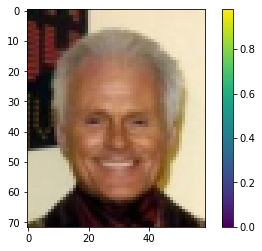

[1 1]


In [9]:
# x를 plt를 이용하여 출력하는 코드를 작성
plt.imshow(x)
plt.colorbar()
plt.show()
print(y)

In [14]:
celeba_small = np.load('celeba_small.npz')
train_images = celeba_small['train_images']
train_labels = celeba_small['train_labels']

test_images = celeba_small['test_images']
test_labels = celeba_small['test_labels']

In [15]:
# dtype을 이용하여 이미지의 np array type을 확인해보세요.
train_images.dtype

dtype('float64')

In [17]:
# 하나의 이미지에 대한 모든 0이 아닌 값을 출력하는 코드를 작성하세요.
train_images[train_images != 0][:10]

array([0.02352941, 0.04313725, 0.05490196, 0.01960784, 0.03921569,
       0.05490196, 0.01977401, 0.03921569, 0.05114656, 0.02352941])

## 데이터 전처리

### 이미지 데이터의 범위 확인

In [23]:
print(train_images.shape, test_images.shape)
print(train_images.dtype, test_images.dtype)

print(train_labels.shape, test_labels.shape)
print(train_labels.dtype, test_labels.dtype)

(2000, 72, 59, 3) (200, 72, 59, 3)
float64 float64
(2000, 2) (200, 2)
int8 int8


In [29]:
# images/labels 이미지 데이터의 최소/최대값을 출력
np.min(train_images), np.max(train_images), np.min(test_images), np.max(test_images)


(0.0, 1.0, 0.0, 1.0)

In [30]:
# (배치, 2)의 labels shape을 (배치, 1)의 shape의 2개의 array로 분리하는 코드를 추가하세요.
from keras.utils import to_categorical

In [32]:
train_labels.shape

(2000, 2)

In [35]:
train_male_labels, train_smile_labels = np.split(train_labels, 2, axis=1)
print(train_male_labels.shape, train_smile_labels.shape)
test_male_labels, test_smile_labels = np.split(test_labels, 2, axis=1)
print(test_male_labels.shape, test_smile_labels.shape)

print(train_male_labels[0], train_smile_labels[0], train_labels[0])

(2000, 1) (2000, 1)
(200, 1) (200, 1)
[0] [0] [0 0]


In [36]:
train_male_labels = to_categorical(train_male_labels)
train_smile_labels = to_categorical(train_smile_labels)
test_male_labels = to_categorical(test_male_labels)
test_smile_labels = to_categorical(test_smile_labels)

In [38]:
print(train_male_labels.shape, train_smile_labels.shape)
print(test_male_labels.shape, test_smile_labels.shape)

(2000, 2) (2000, 2)
(200, 2) (200, 2)


In [40]:
# (배치, 2), (배치, 2)의 labels를 (배치, 4)로 합치는 코드를 작성하세요.
train_labels2 = np.concatenate((train_male_labels, train_smile_labels), axis=1)
test_labels2 = np.concatenate((test_male_labels, test_smile_labels), axis=1)
print(train_labels2.shape)
print(test_labels2.shape)

(2000, 4)
(200, 4)


In [42]:
# (배치, 세로, 가로, 3)인 train_images에서 (5, 세로, 가로, 3)을 획득하는 코드를 작성하세요.
train_images[:5].shape

(5, 72, 59, 3)

(2000, 72, 59, 3)

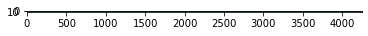

In [49]:
# transpose는 tensor의 axis를 섞는 기능을 합니다.
# 해당 기능을 이용해서 (세로, 가로 * 5, 3)을 작성하는 코드를 작성해보세요.
plt.imshow(train_images[:5].transpose((1,2,0,3)).reshape(15,-1))
train_images.shape

In [59]:
# (72, 295, 3)의 이미지를 plt로 출력해보세요.
train_images[:5].transpose((1, 0, 2 ,3)).reshape((72, -1 , 3)).shape

(72, 295, 3)

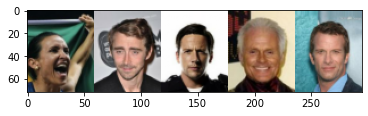

In [58]:
plt.imshow(train_images[:5].transpose((1, 0, 2 ,3)).reshape((72, -1 , 3)))

In [62]:
# smile, male label을 5개 출력하는 코드를 작성해보세요.
for male, smile in zip(train_male_labels[:5], train_smile_labels[:5]):
    print(male, smile)

[1. 0.] [1. 0.]
[0. 1.] [0. 1.]
[0. 1.] [1. 0.]
[0. 1.] [0. 1.]
[0. 1.] [0. 1.]


## 모델 만들기

In [67]:
# input (배치, 72, 59, 3), output (배치, 2)을 처리할 수 있는 모양의 모델 2개를 작성하세요.
from keras.models import Model
from keras.layers import Conv2D, MaxPool2D, Input, Dense, Flatten

def simple_model():
    inputs = Input((72, 59, 3))
    
    x = Conv2D(32, 3, activation='relu')(inputs)
    x = MaxPool2D(2)(x)
    x = Conv2D(64, 3, activation='relu')(x)
    x = MaxPool2D(2)(x)
    x = Conv2D(64, 3, activation='relu')(x)
    x = MaxPool2D(2)(x)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    
    outputs = Dense(2, activation='softmax')(x)
    model = Model(inputs, outputs)
    
    return model

In [68]:
gender_model = simple_model()
smile_model = simple_model()

In [69]:
gender_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 72, 59, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 70, 57, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 35, 28, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 33, 26, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 13, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 5, 64)          0     

In [70]:
smile_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 72, 59, 3)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 70, 57, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 35, 28, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 33, 26, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 13, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 5, 64)          0   

In [74]:
# 만든 모델에 loss는 categorical_crossentropy, optimizer는 adam 매트릭은 accuracy으로 설정하는 코드를 작성하세요.
gender_model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics = ["accuracy"])
smile_model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics = ["accuracy"])

In [77]:
gender_model.get_weights()[0][0][0][0]

array([-0.07358224, -0.08196773, -0.019357  ,  0.11493112,  0.03372051,
       -0.06248662, -0.02740849, -0.03247271, -0.13624845,  0.08822699,
       -0.02491219,  0.05010951, -0.0382138 ,  0.09228894, -0.03916153,
       -0.13359869, -0.13408759, -0.05447441, -0.08106899, -0.06628058,
       -0.08836553,  0.04026715, -0.09897622,  0.11973001,  0.07077134,
       -0.02596762, -0.02588529, -0.08759324, -0.10542879,  0.06411663,
       -0.05297901, -0.08302552], dtype=float32)

In [78]:
smile_model.get_weights()[0][0][0][0]

array([ 0.10688452,  0.10799626, -0.01380495,  0.08325112, -0.08695789,
        0.04309833,  0.04053307,  0.01612926,  0.12176548, -0.11042637,
       -0.09392282, -0.00176331,  0.12569223,  0.09894526,  0.02500489,
       -0.09994479, -0.02492098,  0.08305427,  0.00188887,  0.0099941 ,
       -0.05941304,  0.08740529,  0.07280289, -0.07694841,  0.07459772,
        0.0407486 ,  0.11622132,  0.09157167,  0.00050898,  0.06454127,
       -0.0988836 , -0.08546002], dtype=float32)

In [80]:
# train_images 학습시키고 15 epochs을 돌리고 그 진행 사항을 hist에 저장하는 코드를 작성하세요.
gender_hist = gender_model.fit(train_images, train_male_labels, validation_data=(test_images, test_male_labels), epochs=15, verbose=1)

Epoch 1/15
63/63 [==============================] - 1s 8ms/step - loss: 0.0170 - accuracy: 0.9940 - val_loss: 0.3226 - val_accuracy: 0.9150
Epoch 2/15
63/63 [==============================] - 0s 5ms/step - loss: 0.0258 - accuracy: 0.9900 - val_loss: 0.3813 - val_accuracy: 0.9050
Epoch 3/15
63/63 [==============================] - 0s 5ms/step - loss: 0.0081 - accuracy: 0.9980 - val_loss: 0.3908 - val_accuracy: 0.9300
Epoch 4/15
63/63 [==============================] - 0s 5ms/step - loss: 0.0035 - accuracy: 0.9995 - val_loss: 0.3523 - val_accuracy: 0.9300
Epoch 5/15
63/63 [==============================] - 0s 5ms/step - loss: 0.0016 - accuracy: 0.9995 - val_loss: 0.3656 - val_accuracy: 0.9350
Epoch 6/15
63/63 [==============================] - 0s 5ms/step - loss: 0.0089 - accuracy: 0.9980 - val_loss: 0.3555 - val_accuracy: 0.9350
Epoch 7/15
63/63 [==============================] - 0s 5ms/step - loss: 0.0153 - accuracy: 0.9945 - val_loss: 0.3210 - val_accuracy: 0.9200
Epoch 8/15
63/63 [==

In [83]:
smile_hist = smile_model.fit(train_images, train_male_labels, validation_data=(test_images, test_male_labels), epochs=15, verbose=1)

Epoch 1/15
63/63 [==============================] - 0s 7ms/step - loss: 0.6642 - accuracy: 0.5910 - val_loss: 0.6099 - val_accuracy: 0.7100
Epoch 2/15
63/63 [==============================] - 0s 6ms/step - loss: 0.5171 - accuracy: 0.7590 - val_loss: 0.5340 - val_accuracy: 0.7800
Epoch 3/15
63/63 [==============================] - 0s 5ms/step - loss: 0.4584 - accuracy: 0.7885 - val_loss: 0.5048 - val_accuracy: 0.7850
Epoch 4/15
63/63 [==============================] - 0s 6ms/step - loss: 0.3550 - accuracy: 0.8440 - val_loss: 0.4193 - val_accuracy: 0.8650
Epoch 5/15
63/63 [==============================] - 0s 7ms/step - loss: 0.2617 - accuracy: 0.8960 - val_loss: 0.3915 - val_accuracy: 0.8650
Epoch 6/15
63/63 [==============================] - 0s 5ms/step - loss: 0.1998 - accuracy: 0.9200 - val_loss: 0.2755 - val_accuracy: 0.9000
Epoch 7/15
63/63 [==============================] - 0s 5ms/step - loss: 0.1680 - accuracy: 0.9355 - val_loss: 0.2768 - val_accuracy: 0.8950
Epoch 8/15
63/63 [==

In [84]:
gender_model.get_weights()[0][0][0][0]

array([-0.02044922, -0.09352466,  0.04996714,  0.12191112,  0.08651699,
       -0.06302352, -0.00752543,  0.01693784, -0.16558366,  0.08410764,
       -0.02087105,  0.03940072, -0.09991081,  0.16335623, -0.07262974,
       -0.23361617, -0.10345776, -0.10363238, -0.15722851, -0.07846349,
       -0.0898121 ,  0.07470527, -0.15740694,  0.10436915,  0.12289302,
       -0.02824716,  0.0526405 , -0.13613835, -0.18221752,  0.15367025,
       -0.00809817, -0.1751321 ], dtype=float32)

In [85]:
smile_model.get_weights()[0][0][0][0]

array([ 0.14056581,  0.17543213,  0.03652254,  0.0814098 , -0.13471913,
        0.07686213,  0.01605151,  0.02061659,  0.2066465 , -0.12736094,
       -0.10449898,  0.021083  ,  0.12918884,  0.14547344,  0.07683469,
       -0.11217734, -0.0812588 ,  0.18794851,  0.04047968, -0.00619446,
       -0.05136621,  0.10450558,  0.14546074, -0.10819   ,  0.11150016,
        0.03928731,  0.1261908 ,  0.07269233,  0.00126388,  0.09216302,
       -0.07055715, -0.12447066], dtype=float32)

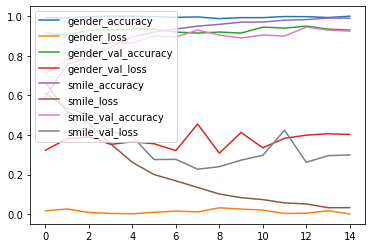

In [89]:
# hist의 accuracy plt의 plot을 이용하여 출력하는 코드를 작성하세요.
plt.plot(gender_hist.history['accuracy'], label = 'gender_accuracy')
plt.plot(gender_hist.history['loss'], label='gender_loss')
plt.plot(gender_hist.history['val_accuracy'], label='gender_val_accuracy')
plt.plot(gender_hist.history['val_loss'], label='gender_val_loss')

plt.plot(smile_hist.history['accuracy'], label = 'smile_accuracy')
plt.plot(smile_hist.history['loss'], label='smile_loss')
plt.plot(smile_hist.history['val_accuracy'], label='smile_val_accuracy')
plt.plot(smile_hist.history['val_loss'], label='smile_val_loss')

plt.legend(loc='upper left')
plt.show()

In [90]:
# 결과 확인
gender_res = gender_model.predict(test_images[1:2])
gender_res.shape

(1, 2)

In [91]:
smile_res = smile_model.predict(test_images[1:2])
smile_res.shape

(1, 2)

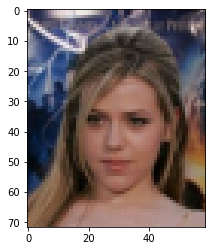

In [95]:
# 모델에 test_mages 중 1장을 넣고 결과를 받는 코드를 작성하세요.
plt.imshow(test_images[1])
plt.show()

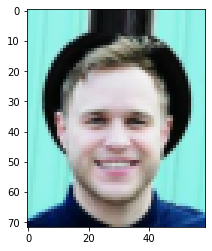

In [96]:
plt.imshow(test_images[0])
plt.show()

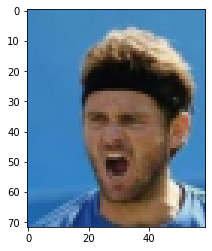

In [97]:
plt.imshow(test_images[2])
plt.show()

In [98]:
from keras.models import Model
from keras.layers import Conv2D, MaxPool2D, Input, Dense, Flatten, Concatenate

In [99]:
def multi_model():
    inputs = Input((72,59,3))
    
    layer1 = Conv2D(32,3, activation='relu')(inputs)
    layer2 = MaxPool2D(2)(layer1)
    layer3 = Conv2D(64,3, activation='relu')(layer2)
    layer4 = MaxPool2D(2)(layer3)
    layer5 = Conv2D(64,3, activation='relu')(layer4)
    layer6 = MaxPool2D(2)(layer5)
    
    layer7 = Flatten()(layer6)
    latent_vector = Dense(64, activation='relu')(layer7)
    
    gender_outputs = Dense(2, activation='softmax')(latent_vector)
    smile_outputs = Dense(2, activation='softmax')(latent_vector)
    
    outputs = Concatenate(axis=1)([gender_outputs, smile_outputs])
    
    model = Model(inputs, outputs)
    return model

In [100]:
model2 = multi_model()
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 72, 59, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 70, 57, 32)   896         input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 35, 28, 32)   0           conv2d_6[0][0]                   
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 33, 26, 64)   18496       max_pooling2d_6[0][0]            
____________________________________________________________________________________________

In [101]:
model2.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics = ["accuracy"])

In [103]:
hist1 = model2.fit(train_images, train_labels2, validation_data=(test_images, test_labels2), epochs=15, verbose=1)

Epoch 1/15
63/63 [==============================] - 0s 7ms/step - loss: 2.6654 - accuracy: 0.5165 - val_loss: 2.5563 - val_accuracy: 0.6250
Epoch 2/15
63/63 [==============================] - 0s 5ms/step - loss: 2.4535 - accuracy: 0.6930 - val_loss: 2.4512 - val_accuracy: 0.7250
Epoch 3/15
63/63 [==============================] - 0s 5ms/step - loss: 2.2275 - accuracy: 0.7540 - val_loss: 2.1442 - val_accuracy: 0.7200
Epoch 4/15
63/63 [==============================] - 0s 5ms/step - loss: 2.0184 - accuracy: 0.7245 - val_loss: 2.0612 - val_accuracy: 0.6250
Epoch 5/15
63/63 [==============================] - 0s 5ms/step - loss: 1.9135 - accuracy: 0.7100 - val_loss: 2.0997 - val_accuracy: 0.6600
Epoch 6/15
63/63 [==============================] - 0s 6ms/step - loss: 1.8126 - accuracy: 0.6995 - val_loss: 1.9756 - val_accuracy: 0.6350
Epoch 7/15
63/63 [==============================] - 0s 6ms/step - loss: 1.7541 - accuracy: 0.6945 - val_loss: 1.9440 - val_accuracy: 0.6550
Epoch 8/15
63/63 [==

In [106]:
res = model2.predict(test_images[3:5])
print(len(res))
print(res[0].shape, res[1].shape)

2
(4,) (4,)
